# Seminar work
# Adjust to the material parameters in the PO-LF-LM-EL-SH app


@author: rosoba

## Idealization of the pull-out problem
The one-dimensional idealization of the pull-out looks as follows

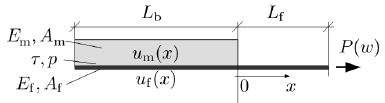

## Model parameters

The parameters and variables involved in the are grouped according geometry, material behavior, measured response, internal state and subsidiary integration parameters that will be resolved during the model derivation. In this classification we also associate the mathematical symbols with the Python variable name introduced in the next cell.

**Geometrical variables:**

| Python | Parameter | Description | 
| :- | :-: | :- |
| `A_f` | $A_\mathrm{f}$ |  Cross section area modulus of the reinforcement |
| `A_m` | $A_\mathrm{m}$ |  Cross section area modulus of the matrix |
| `p_b` | $p_\mathrm{b}$ |  Perimeter of the reinforcement                  |
| `L_b` | $L_\mathrm{b}$ |  Length of the bond zone of the pulled-out bar   |
| `x`   | $x$            |  Longitudinal coordinate |

**Material parameters:**

| Python | Parameter | Description | 
| :- | :-: | :- |
| `E_f`     | $E_\mathrm{f}$ |  Young's modulus of the reinforcement |
| `E_m`     | $E_\mathrm{m}$ |  Young's modulus of the matrix        |
| `MATS`    | $\tau(s)$      |  Multi-linear bond-slip model         |

(`MATS` is used to denote "Material Time Stepper" -- equivalent to user-subroutine in Abaqus, or user material in ATENA) 

**Control parameter:**

| Python | Parameter | Description | 
| :- | :-: | :- |
| `P` | $P$ | Pullout force |
| `w` | $w$ | pullout control  displacement

**State parameter:**

There are no state parameters included. 

 - What is the consequence? The material has no memory.
 - What happens upon unloading?

**Let's import the packages:**

In [1]:
%matplotlib widget
import numpy as np # numerical package
import matplotlib.pyplot as plt # plotting package
import ipywidgets as ipw

## Numerical model of pull-out provided in BMCS Tool Suite 
The presented function is the simplest model provided in a general-purpose nonlinear finite-element simulator `BMCS-Tool-Suite`. This code can be installed in your anaconda environment by issuing the installation command

`pip install --upgrade bmcs`

After the installation it should be possible to import the `PullOutModel` by issuing

In [2]:
A_f = 0.5**2 * np.pi
A_m = 10 * 10.
P_b = np.pi * 1.0
E_f = 280000.
E_m = 28000.
L_b = 200.
s_data = '0, 0.06, 0.3, 1, 2'
tau_data = '0., 1, 0.0, 0.0, 0.0'

In [3]:
from bmcs.pullout.pullout_sim import PullOutModel
po = PullOutModel(n_e_x=60, k_max=200, w_max=1.0)
po

In [4]:
po.sim.tline.step = 0.05
po.sim.tloop.k_max = 200
po.fixed_boundary = 'non-loaded end (matrix)'
po.loading_scenario.trait_set(loading_type='cyclic',
                              amplitude_type='constant',
                              loading_range='non-symmetric'
                              )
po.loading_scenario.trait_set(number_of_cycles=1,
                              unloading_ratio=0.98,
                              )
po.geometry.trait_set(L_x=1.0)
po.cross_section.trait_set(A_f=A_f, P_b=P_b, A_m=A_m)

## Run the simulation
The model object `po` contains the non-linear threaded simulator `sim` as its attribute. To be sure that the state arrays and history variables are zeroed and reset run the methods `stop` first. After that, the simulation can be started.

In [9]:
fig1, (ax_geo, ax_bs) = plt.subplots(2,1, figsize=(4,5), 
                                   tight_layout=True)
fig2, ((ax_Pw, ax_s),
      (ax_eps, ax_sig))= plt.subplots(2,2,figsize=(10,6),
                                   tight_layout=True)
fig3, (ax_G, ax_dG) = plt.subplots(1,2, figsize=(10,4), 
                                   tight_layout=True)
ax_sf = ax_s.twinx()

fig1.canvas.header_visible = False
fig2.canvas.header_visible = False
fig3.canvas.header_visible = False
fig2.canvas.layout.min_height = '400px'

po.sim.stop()
po.sim.run()

def update_bs_law(change):
    s = slip_values.value
    tau = tau_values.value
    ax_bs.clear()
    po.mats_eval.s_data = s
    po.mats_eval.tau_data = tau
    po.mats_eval.update_bs_law = True
    po.mats_eval.bs_law.replot()
    po.mats_eval.bs_law.plot(ax_bs, color='green')
    fig1.canvas.draw()
    fig1.canvas.flush_events()

slip_values = ipw.Text(
    value=s_data,
    placeholder='Type something',
    description='slip values',
    disabled=False
)

tau_values = ipw.Text(
    value=tau_data,
    placeholder='Type something',
    description='tau values:',
    disabled=False
)

update_bs_button = ipw.Button(
    description='Update bond-slip',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Update bond-slip law',
    icon='check'
)

update_bs_button.on_click(update_bs_law)
bs_input = ipw.VBox([update_bs_button, slip_values, tau_values])

update_bs_law(True)

def clear_plots():
    print('cleared plots')
    ax_geo.clear()
    ax_Pw.clear()
    ax_eps.clear()
    ax_sig.clear()
    ax_s.clear()
    ax_sf.clear()
    ax_G.clear()
    ax_dG.clear()

def plot_state(t):
    clear_plots()
    po.plot_geo(ax_geo,t)
    po.hist.plot_Pw(ax_Pw,t)
    po.plot_eps_p(ax_eps, t)
    po.plot_sig_p(ax_sig, t)
    po.plot_s(ax_s, t)
    po.plot_sf(ax_sf, t)
    po.hist.plot_G_t(ax_G,0.9)
    po.hist.plot_dG_t(ax_dG,1)
    fig2.canvas.draw()
    fig2.canvas.flush_events()

def update_material(w_max, support_at, L_b, P_b, A_f, A_m, E_f, E_m, k_max, step):
    print('updating material')
    po.w_max = w_max
    po.geometry.L_x = L_b
    po.cross_section.A_f = A_f
    po.cross_section.P_b = P_b
    po.cross_section.A_m = A_m
    po.mats_eval.E_f = E_f
    po.mats_eval.E_m = E_m
    po.k_max = k_max
    po.sim.tloop.k_max = k_max
    po.sim.tline.step = step

@run_output.capture(clear_output=True)
def run_sim(run_state):
    print('running simulation')
    po.sim.stop()
    po.sim.run()
    print('simulation finished')
    plot_state(t_slider.value)
    tab.selected_index = 1

support_dd = ipw.Dropdown(
    options=[('non-loaded end (matrix)'), ('loaded end (matrix)')],
    value='loaded end (matrix)',
    description='support at:',
    disabled=False,
)

t_slider = ipw.FloatSlider(description='history slider', 
                           value=0, min=0, max=1, step=0.1, continuous_update=False)
m_sliders = dict(w_max=ipw.FloatText(description='w_max', value=1),
                 support_at = support_dd,
                 L_b = ipw.FloatText(description='L_b', value=L_b),
                 P_b = ipw.FloatText(description='P_b', value=P_b),
                 A_m = ipw.FloatText(description='A_m', value=A_m),
                 A_f = ipw.FloatText(description='A_f', value=A_f),
                 E_m = ipw.FloatText(description='E_m', value=E_m),
                 E_f = ipw.FloatText(description='E_f', value=E_f),
                 k_max = ipw.IntSlider(description='iter n', value=300, min=10, max=1000, step=20, continuous_update=False), 
                 step = ipw.FloatSlider(description='step size',value=0.05, min=0.001, max=0.2, step=0.005, continuous_update=False))

run_button = ipw.Button(
    description='Run simulation',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Start the simulation',
    icon='check'
)

run_button.on_click(run_sim)
out1 = ipw.interactive_output(plot_state, {'t':t_slider});
out2 = ipw.interactive_output(update_material, m_sliders );
out_area = ipw.HBox([out1, out2, run_output])
s_list = [ val for val in m_sliders.values() ]


# Layout
input_param_area = ipw.VBox(s_list)
input_area = ipw.VBox([run_button, input_param_area, bs_input])
plot_area1 = ipw.HBox([input_area, fig1.canvas])
plot_area2 = ipw.VBox([fig2.canvas, t_slider])
plot_area3 = ipw.VBox([fig3.canvas, t_slider])
tab = ipw.Tab()
tab.children = [plot_area1, plot_area2,plot_area3]
tab.set_title(0,'Input')
tab.set_title(1,'Plot response')
tab.set_title(2,'Plot energy')
app_area = ipw.VBox([tab, out_area])
display(app_area)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Rendering individual outputs

In [ ]:
fix, ax = plt.subplots(1,1, figsize=(8,3),tight_layout=True)
po.hist.plot_Pw(ax,1)

All plot functions accept the scalar parameter between the start and end state in the range (0,1)

In [ ]:
fix, (ax1, ax2) = plt.subplots(1,2, figsize=(8,3),tight_layout=True)
po.plot_eps_p(ax1, 0.2)
po.plot_s(ax2, 0.2)
ax22 = ax2.twinx()
po.plot_sf(ax22, 0.2)


To use the plots of the simulations in documents, the diagrams of the above simulation
are replotted here with the goal to show the code snippets producing individual diagrams.

In [ ]:
fix, (ax1, ax2) = plt.subplots(1,2, figsize=(8,3),tight_layout=True)
po.hist.plot_G_t(ax1,0.9)
po.hist.plot_dG_t(ax2,1)